In [1]:
import pandas as pd
from IPython.display import display, Markdown
import os
from contextlib import contextmanager
from datetime import date
from dateutil.relativedelta import relativedelta
import numpy as np

# import custom functions from 'lib' folder
import sys
sys.path.append('../lib/')
from functions import plot_line_chart


# Total patients with anticoagulants per month, and duplicate issues

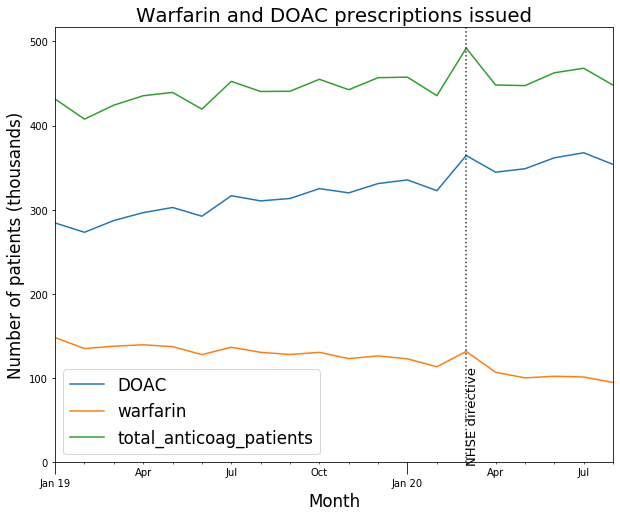

In [2]:
#open out1 from csv file
out1 = pd.read_csv(os.path.join("..","output","warf_doac_issues.csv"))
out1 = out1.set_index('Startmonth')

# plot chart
titles = ["Warfarin and DOAC prescriptions issued"]
figname = "warf_doac_issues"
plot_line_chart([out1], titles, filename=figname)

    
# patients having both Warfarin and DOAC prescriptions issued on the same day (displayed later)  
#out4 = out1.join(out3)


# Patients with DOAC and warfarin repeats

### Of patients who had either anticoagulant issued each month, *who has repeats* and were they *started together*


## Patients with an anticoagulant issued each month, and of whom, how many were on a warfarin or DOAC repeat prescription

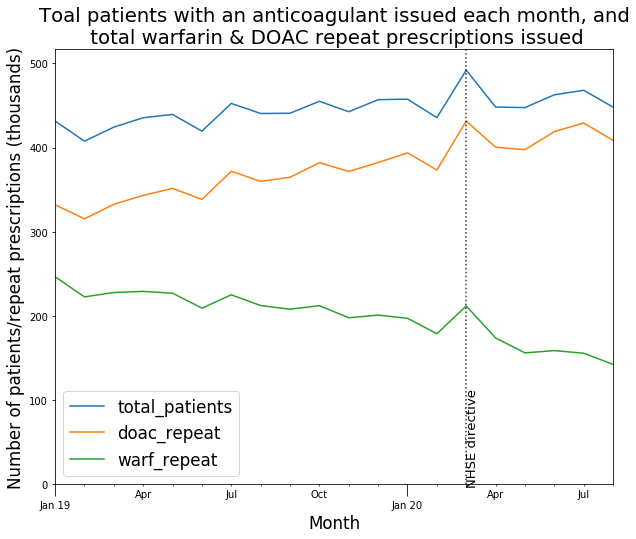

In [3]:
out = pd.read_csv(os.path.join("..","output","warf_doac_repeats.csv"))
out = out.set_index('issuemonth')

dfp = out[["total_patients","doac_repeat","warf_repeat"]]
    
display(Markdown(f"## Patients with an anticoagulant issued each month, and of whom, how many were on a warfarin or DOAC repeat prescription"))
titles = ["Toal patients with an anticoagulant issued each month, and\n total warfarin & DOAC repeat prescriptions issued"]
figname = "warf_doac_repeats.png"
plot_line_chart([dfp], titles, filename=figname, ylabels={0:"Number of patients/repeat prescriptions"})

# Prescriptions issued on same day, and Repeats initiated on same day

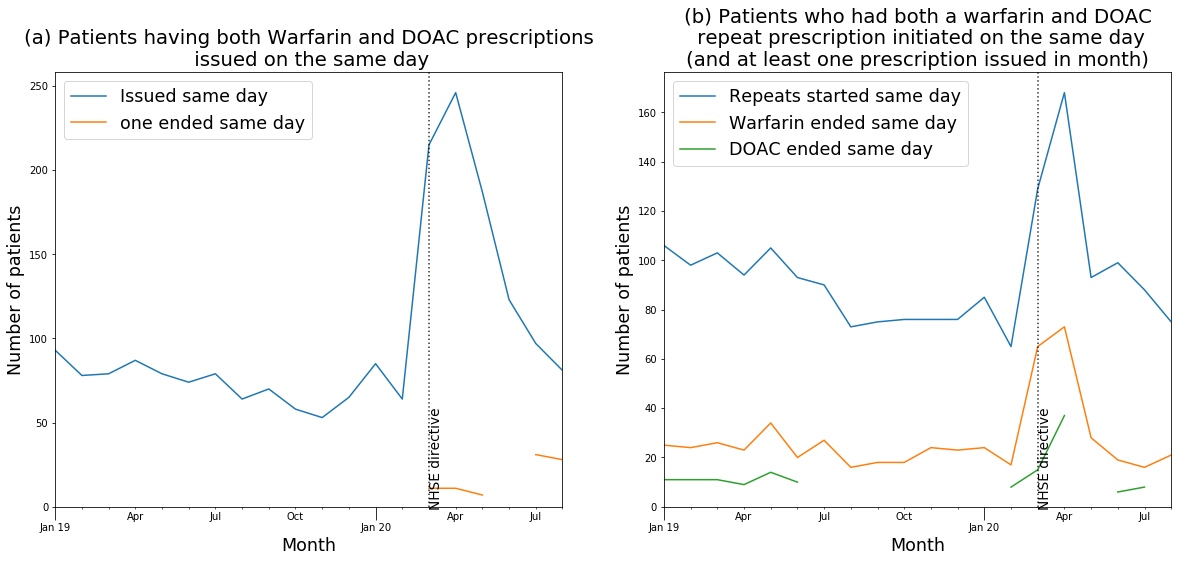

In [4]:
dfp1 = pd.read_csv(os.path.join("..","output","same_day_issues.csv"))
dfp1 = dfp1.set_index('Startmonth')

dfp2 = pd.read_csv(os.path.join("..","output","same_day_repeats.csv"))
dfp2 = dfp2.set_index('issuemonth')

# plot charts
titles = ["(a) Patients having both Warfarin and DOAC prescriptions\n issued on the same day",
          "(b) Patients who had both a warfarin and DOAC\n repeat prescription initiated on the same day\n(and at least one prescription issued in month)"]
 
dfs = [dfp1, dfp2]
figname = "same_day"
plot_line_chart(dfs, titles, filename=figname, loc="upper left")

## Patients starting a DOAC repeat per month, and of whom, how many switched from Warfarin
### This is repeats only and does not take into account any prescriptions being issued

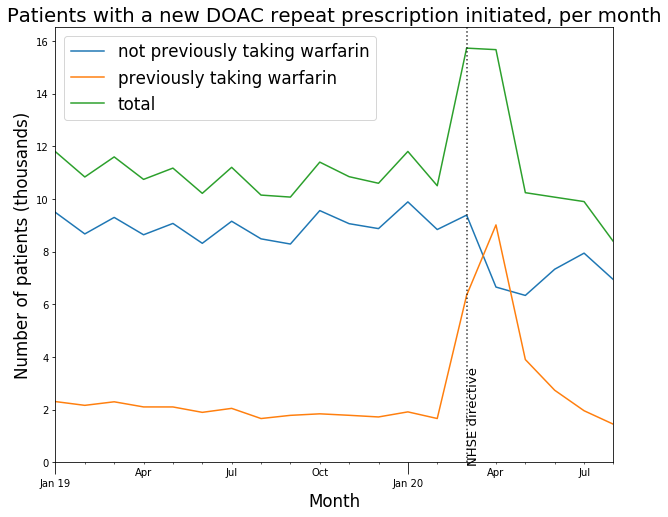

In [5]:
dfp3 = pd.read_csv(os.path.join("..","output","doac_repeats.csv"))
dfp3 = dfp3.set_index('doacStartmonth')


titles = ["Patients with a new DOAC repeat prescription initiated, per month"]
figname = "doac_repeat"
plot_line_chart([dfp3], titles, filename=figname,  loc='upper left')

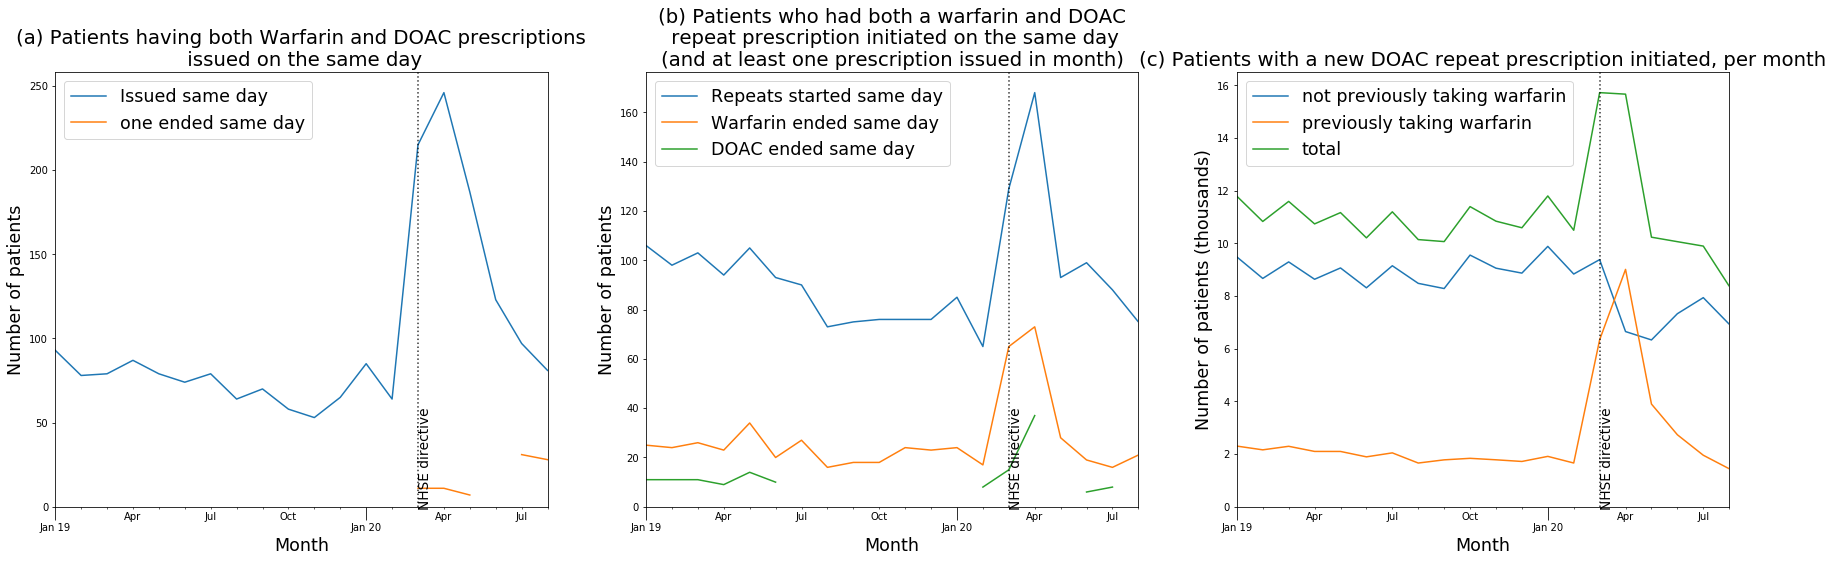

In [6]:
###TEST###
dfs = [dfp1, dfp2, dfp3]
titles = ["(a) Patients having both Warfarin and DOAC prescriptions\n issued on the same day",
          "(b) Patients who had both a warfarin and DOAC\n repeat prescription initiated on the same day\n(and at least one prescription issued in month)",
          "(c) Patients with a new DOAC repeat prescription initiated, per month"]
figname = "same_day2" 
plot_line_chart(dfs, titles, filename=figname,  loc="upper left")

## Extract patients on Warfarin during baseline and count how many switched to DOAC

# INR testing

In [7]:
#df_out.replace([0,1,2,3,4,5],np.NaN).to_csv(os.path.join("..","output","inr_testing.csv"))
#df_out2.replace([0,1,2,3,4,5],np.NaN).to_csv(os.path.join("..","output","high_inr.csv"))

## INR tests for patients on Warfarin (and not DOAC) in previous 3 months

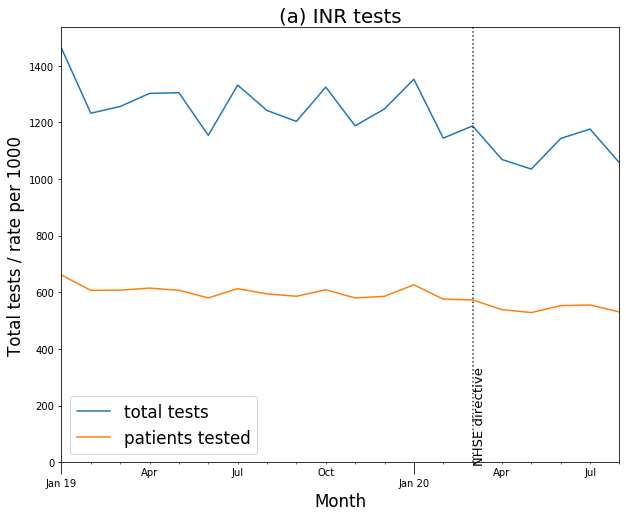

In [8]:
dfp4 = pd.read_csv(os.path.join("..","output","inr_testing.csv"),index_col=0)
dfp4["INR_month"] = pd.to_datetime(dfp4["INR_month"])
dfp4 = dfp4.set_index("INR_month")

dfp4["patients tested"] = 1000*dfp4["patient_count"]/dfp4["denominator"]
dfp4["total tests"] = 1000*dfp4["test_count"]/dfp4["denominator"]
titles = ["(a) INR tests"]
figname = "inr_testing_label2"
plot_line_chart([dfp4[["total tests","patients tested"]]], titles, ylabels={0:"Total tests / rate per 1000"}, filename=figname
                )


In [9]:
dfp5 = pd.read_csv(os.path.join("..","output","high_inr.csv"),index_col=0)
dfp5["high_INR_month"] = pd.to_datetime(dfp5["high_INR_month"])
#dfp5 = dfp5.set_index("high_INR_month")
dfp5["patient_count_equal_greater_8"] = dfp5["patient_count_over_8"] + dfp5["patient_count_equal_8"]

dfp4 = dfp4.reset_index()

dfp5.head()

,high_INR_month,patient_count_over_8,patient_count_equal_8,denominator,patient_count_equal_greater_8
0,2019-01-01,243,188,204626,431
0,2019-02-01,175,172,201290,347
0,2019-03-01,177,147,197840,324
0,2019-04-01,190,121,194698,311
0,2019-05-01,169,142,191462,311


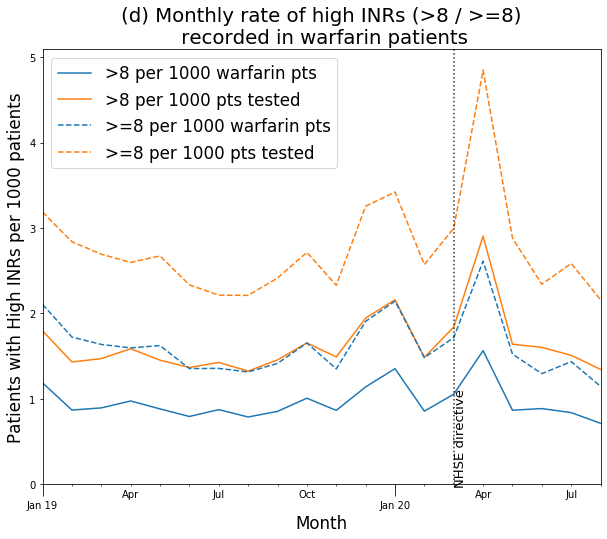

In [14]:
#dfp5 = pd.read_csv(os.path.join("..","output","high_inr.csv"),index_col=0)
#dfp5["high_INR_month"] = pd.to_datetime(dfp5["high_INR_month"])
#dfp5 = dfp5.set_index("high_INR_month")

dfp6 = dfp4.drop("denominator",1).merge(dfp5, left_on="INR_month", right_on="high_INR_month").drop("INR_month",1)
#dfp6["high_INR_month"] = pd.to_datetime(dfp6["high_INR_month"])
dfp6 = dfp6.set_index("high_INR_month")

dfp7 = dfp6.copy()
dfp7[">8 per 1000 warfarin pts"] = 1000*dfp7["patient_count_over_8"]/dfp7["denominator"]
dfp7[">8 per 1000 pts tested"] = 1000*dfp7["patient_count_over_8"]/dfp7["patient_count"]

dfp7[">=8 per 1000 warfarin pts"] = 1000*dfp7["patient_count_equal_greater_8"]/dfp7["denominator"]
dfp7[">=8 per 1000 pts tested"] = 1000*dfp7["patient_count_equal_greater_8"]/dfp7["patient_count"]

figname = "high_inr"
titles = ["(d) Monthly rate of high INRs (>8 / >=8)\n recorded in warfarin patients"]
plot_line_chart([dfp7[[">8 per 1000 warfarin pts", ">8 per 1000 pts tested",
                       ">=8 per 1000 warfarin pts", ">=8 per 1000 pts tested"]]],
                titles,  loc="upper left",
                ylabels={0:"Patients with High INRs per 1000 patients"}, 
                filename=figname)